# Part 3 - Data Exploring
---
### Papers Past Topic Modeling

<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc, subprocess
sys.path.insert(0, '../utils')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from pyspark.sql import functions as F
from pyspark.sql.types import *
from utils import conf_pyspark, load_dataset
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
%matplotlib inline
dpi=80

In [2]:
# intiate PySpark
sc, spark = conf_pyspark()

sc

[('spark.app.id', 'local-1548214150272'),
 ('spark.driver.host', 'x99.hub'),
 ('spark.app.name', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.maxResultSize', '4g'),
 ('spark.driver.port', '33146')]


<SparkContext master=local[*] appName=local>

## 1 Load Data

**Load clean dataset:**

In [3]:
df = load_dataset('clean', spark)

In [4]:
n_row = df.count()
print('Shape of dataframe: ({}, {})'.format(n_row, len(df.columns)))
df.sample(False, 0.00001).limit(10).toPandas().head(10)

Shape of dataframe: (15121970, 7)


,id,publisher,region,date,ads,title,content
0,1891865,Clutha Leader,Otago,1875-03-18,True,Page 4 Advertisements Column 2,"AUCTION i^LE. BOOKS ! BOOKS ! I BOOKS ! ! ! ""A/TR ROBERT GBIGOEy AUCTIONEER, .* • • ' Has received instructions to I..."
1,1951976,Clutha Leader,Otago,1876-11-17,False,General Intelligence.,General Intelligence.The English cricketers have .reached Adelaide all well. They play the first match there next we...
2,2365270,Grey River Argus,West Coast,1871-01-07,False,BOROUGH COUNCIL.,BOROUGH COUNCIL.The adjourned annual meeting of the Council was held in the Town Hall last nigHfc. Present— E. Wicke...
3,2486085,Grey River Argus,West Coast,1872-01-24,False,ENGLISH MAIL NEWS.,ENGLISH MAIL NEWS.Mr Ruskin has been elected Recio.r of St Andrews University. Lieutenant-General Sir J. Yorke Scarl...
4,2500144,Feilding Star,Manawatu-Wanganui,1890-11-15,False,LEAPING AND JUMPING COMPETITIONS.,"LEAPING AND JUMPING COMPETITIONS.Hunters' Competition. Prizes. LlO, L5, and L 2; minimum weight, 12st — Mr P. Wooton..."
5,2666895,New Zealand Illustrated Magazine,unknown,1900-05-01,False,IN THE PUBLIC EYE.,"IN THE PUBLIC EYE.Bishop Wilson, of Melanesia, has recentlyvisited Auckland. He BISHOP WILSON. , , , - , . took char..."
6,2694469,Nelson Examiner and New Zealand Chronicle,Nelson,1849-11-17,False,LATEST DATES OF NEWSPAPERS RECEIVED.,"LATEST DATES OF NEWSPAPERS RECEIVED.London July 6 Sydney Oct. Iff Port Phillip Sept. 1 Adelaide ......... Sept, 8Auc..."
7,2820720,Mataura Ensign,Otago,1888-10-30,True,Page 6 Advertisements Column 1,"We hear that the Rev, J Standring, of Nelson, is shortly to assume the pastorate of the Baptist Church at luvercargi..."
8,2850521,Ohinemuri Gazette,Waikato,1896-06-03,True,Page 4 Advertisements Column 4,"1.""%. ;; ii o . JjJ •SURGEON Uii TidT, ■ ■ Victoria-strce CNext Mucky, L-.g.-ui, and Co) Auckland. Mr Klkin may bo c..."
9,2860944,Manawatu Herald,Manawatu-Wanganui,1890-10-25,True,Page 3 Advertisements Column 3,"Stoc& and Pi\ duce Coir n i FARMERS EXCHANGE. FOR SALE. QEED POTATOES Apply to J. Li. Stvnsell, Foxton. ONE *ET of T..."


## 2 Label

**There are only one label - "ads" - that we extracted form raw dataset, check the distribution of "ads":**

In [5]:
n_ads = df.where(F.col('ads') == True).count()
print('ADs number:{0}\nADs proportion:{1}\n'.format(n_ads, 100*n_ads/n_row))

ADs number:4208973
ADs proportion:27.83349656162524



In [6]:
x = ['ADs', 'Total']
value = [n_ads/1000000, n_row/1000000]
x_pos = [i for i, _ in enumerate(x)]

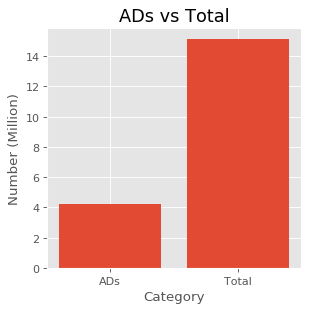

In [7]:
plt.figure(figsize=(4, 4), dpi=dpi)
plt.bar(x_pos, value)
plt.xlabel('Category')
plt.ylabel('Number (Million)')
plt.title("ADs vs Total", fontdict=dict(size=16))
plt.xticks(x_pos, x)
plt.tight_layout()
plt.show()

**In the clean dataset there are:**
* **4,208,973** ADs samples;
* accounting **27.8%** in total.

**The ratio of ADs is neglectable, it is worthwhile to seperately analyze ADs as a subset.**

## 3 Papers

**Considering each row in the dataset is a sample, each paper consisting multiple samples. Assuming each publisher publishs at most one paper in the same day, we could group publisher and date columns to get the real number of papers of each day.**

In [8]:
path = r'../temp/region.csv'

df_region = spark.createDataFrame(pd.read_csv(path, 
                                  header=None, 
                                  index_col=None, 
                                  names = ['publisher_', 'region'],
                                  encoding='utf8'))

df_paper = (df.groupBy('publisher', 'date').count()
            .join(df_region, df.publisher == df_region.publisher_, how='left')
            .select('publisher', 'region', 'date')
            .toPandas().sort_values('date', ascending=True).reset_index(drop=True))

df_paper.region = df_paper.region.fillna('unknown')

df_paper['date'] = pd.to_datetime(df_paper['date'])

In [9]:
print('Shape of dataframe:', df_paper.shape)
df_paper.sample(5)

Shape of dataframe: (340348, 3)


,publisher,region,date
100530,Timaru Herald,Canterbury,1883-11-17
17588,Nelson Evening Mail,Nelson,1867-01-21
58889,Waikato Times,Waikato,1877-05-26
238898,Otago Daily Times,Otago,1901-11-13
32270,Star,Canterbury,1871-06-26


### 3.1 Papers Distribution by Publisher

In [10]:
df_paper_count = (df_paper.groupby('publisher').size()
                  .reset_index(name='count')
                  .sort_values('count', ascending=False).reset_index(drop=True))

df_paper_count.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
publisher,Evening Post,Otago Daily Times,Grey River Argus,Colonist,Wanganui Chronicle,Nelson Evening Mail,Thames Star,West Coast Times,Marlborough Express,Wanganui Herald,Star,Poverty Bay Herald,Hawera & Normanby Star,Taranaki Herald,Auckland Star,Ashburton Guardian,Timaru Herald,North Otago Times,Feilding Star,Southland Times,Hawke's Bay Herald,Bay Of Plenty Times,Daily Southern Cross,Daily Telegraph,Tuapeka Times,Taranaki Daily News,Wairarapa Daily Times,Mataura Ensign,Akaroa Mail and Banks Peninsula Advertiser,Ellesmere Guardian,Wellington Independent,Inangahua Times,Northern Advocate,Bruce Herald,Nelson Examiner and New Zealand Chronicle,Ohinemuri Gazette,Clutha Leader,Otago Witness,Waikato Times,Manawatu Herald,Bush Advocate,Manawatu Standard,"Rodney and Otamatea Times, Waitemata and Kaipara Gazette",Observer,New Zealand Tablet,Manawatu Times,Otautau Standard and Wallace County Chronicle,NZ Truth,Lyttelton Times,New Zealand Spectator and Cook's Strait Guardian,New Zealander,Kaipara and Waitemata Echo,Oxford Observer,Te Aroha News,Waiapu Church Gazette,New Zealand Gazette and Wellington Spectator,Hutt News,New Zealand Free Lance,Waimate Daily Advertiser,New Zealand Colonist and Port Nicholson Advertiser,Hawke's Bay Weekly Times,Kai Tiaki,New Zealand Illustrated Magazine,Progress,Fair Play,New Zealand Advertiser and Bay of Islands Gazette,Albertland Gazette,Waiapu Church Times
count,23556,16518,14667,13558,12339,12238,11953,11869,11739,11587,11437,11364,10676,10226,10035,9514,9068,8894,8611,8473,7943,6616,6093,5165,4662,4647,4277,4210,4063,3980,3900,3763,3720,3614,3161,3028,2965,2825,2142,2045,2039,1866,1782,1704,1703,1505,1285,1200,1007,995,701,500,448,437,411,368,296,286,231,105,90,88,51,35,27,27,11,9


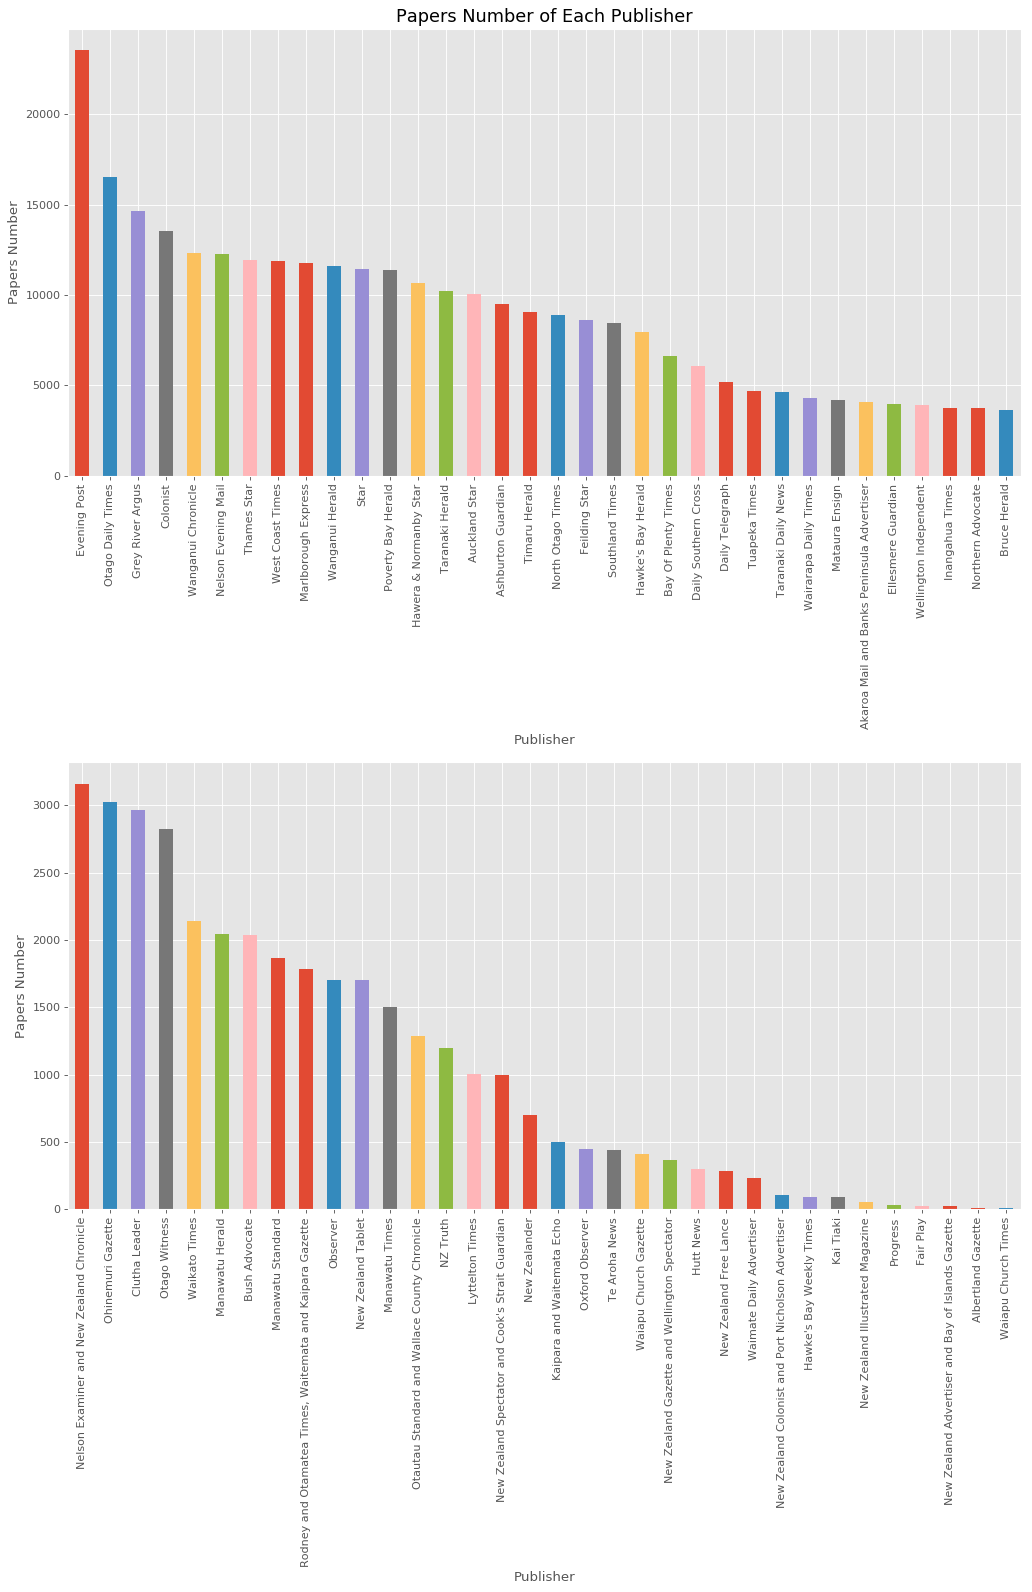

In [11]:
# index of half dataframe, split dataframe to plot better
i = int(df_paper_count.shape[0]/2)

# plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 20), dpi=dpi)
fig.subplots_adjust(hspace=0.6)
df_paper_count.iloc[:i].plot(ax=axes[0], 
                             kind='bar', 
                             x='publisher', 
                             y='count', 
                             legend=False)
df_paper_count.iloc[i:].plot(ax=axes[1], 
                             kind='bar', 
                             x='publisher', 
                             y='count', 
                             legend=False)
axes[0].set_title('Papers Number of Each Publisher', fontdict=dict(size=16))
axes[0].set_ylabel('Papers Number')
axes[0].set_xlabel('Publisher')
axes[1].set_ylabel('Papers Number')
axes[1].set_xlabel('Publisher')
fig.tight_layout()
plt.show()

### 3.2 Papers Distribution by Region

In [12]:
df_region_count = (df_paper.groupby('region').size()
                   .reset_index(name='count')
                   .sort_values('count', ascending=False).reset_index(drop=True))

df_region_count.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
region,Otago,Canterbury,Manawatu-Wanganui,Wellington,West Coast,Nelson,Taranaki,Auckland,Waikato,Hawke's Bay,Marlborough,Gisborne,Bay of Plenty,Northland,unknown,National
count,53446,39748,37953,33783,30299,28957,25549,20826,17560,15237,11739,11364,6616,3747,2324,1200


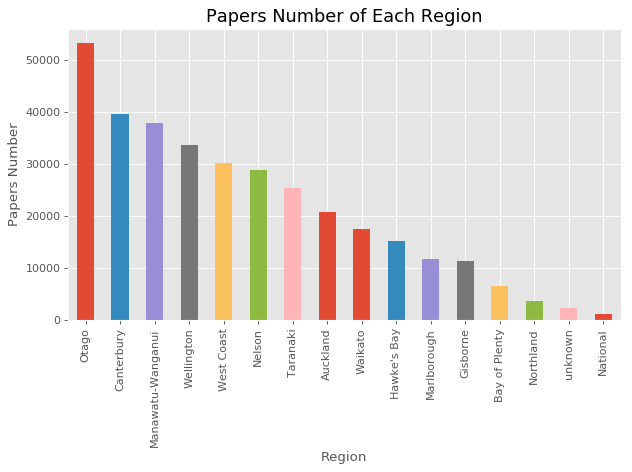

In [13]:
# plot
fig, axes = plt.subplots(figsize=(8, 6), dpi=dpi)
df_region_count.plot(ax=axes, 
                     kind='bar', 
                     x='region', 
                     y='count', 
                     legend=False)
axes.set_title('Papers Number of Each Region', fontdict=dict(size=16))
axes.set_ylabel('Papers Number')
axes.set_xlabel('Region')
axes.set_ylabel('Papers Number')
axes.set_xlabel('Region')
fig.tight_layout()
plt.show()

### 3.3 Papers Distribution Over Time

**Convert dataframe paper dataframe** `df_paper` **time series**:

In [14]:
# convert dataframe to time series
df_paper_ts = (df_paper
               .groupby([df_paper['date']])
               .size()
               .reset_index(name='count')
               .sort_values('date', ascending=True))
df_paper_ts = df_paper_ts.set_index('date')
df_paper_ts.sort_index()
df_paper_ts.T

date,1839-08-21 00:00:00,1839-09-06 00:00:00,1840-04-18 00:00:00,1840-04-25 00:00:00,1840-05-02 00:00:00,1840-05-09 00:00:00,1840-05-16 00:00:00,1840-05-23 00:00:00,1840-05-30 00:00:00,1840-06-06 00:00:00,1840-06-13 00:00:00,1840-06-15 00:00:00,1840-06-19 00:00:00,1840-06-20 00:00:00,1840-06-25 00:00:00,1840-06-27 00:00:00,1840-07-02 00:00:00,1840-07-04 00:00:00,1840-07-09 00:00:00,1840-07-11 00:00:00,1840-07-16 00:00:00,1840-07-18 00:00:00,1840-07-23 00:00:00,1840-07-25 00:00:00,1840-07-30 00:00:00,1840-08-01 00:00:00,1840-08-06 00:00:00,1840-08-08 00:00:00,1840-08-13 00:00:00,1840-08-15 00:00:00,1840-08-20 00:00:00,1840-08-22 00:00:00,1840-08-27 00:00:00,1840-08-29 00:00:00,1840-09-03 00:00:00,1840-09-05 00:00:00,1840-09-10 00:00:00,1840-09-12 00:00:00,1840-09-17 00:00:00,1840-09-19 00:00:00,1840-09-24 00:00:00,1840-10-01 00:00:00,1840-10-03 00:00:00,1840-10-08 00:00:00,1840-10-10 00:00:00,1840-10-15 00:00:00,1840-10-17 00:00:00,1840-10-22 00:00:00,1840-10-24 00:00:00,1840-10-29 00:00:00,1840-10-31 00:00:00,1840-11-05 00:00:00,1840-11-07 00:00:00,1840-11-12 00:00:00,1840-11-14 00:00:00,1840-11-19 00:00:00,1840-11-21 00:00:00,1840-11-26 00:00:00,1840-11-28 00:00:00,1840-12-03 00:00:00,...,1945-10-22 00:00:00,1945-10-23 00:00:00,1945-10-24 00:00:00,1945-10-25 00:00:00,1945-10-26 00:00:00,1945-10-27 00:00:00,1945-10-29 00:00:00,1945-10-30 00:00:00,1945-10-31 00:00:00,1945-11-01 00:00:00,1945-11-02 00:00:00,1945-11-03 00:00:00,1945-11-05 00:00:00,1945-11-06 00:00:00,1945-11-07 00:00:00,1945-11-08 00:00:00,1945-11-09 00:00:00,1945-11-10 00:00:00,1945-11-12 00:00:00,1945-11-13 00:00:00,1945-11-14 00:00:00,1945-11-15 00:00:00,1945-11-16 00:00:00,1945-11-17 00:00:00,1945-11-19 00:00:00,1945-11-20 00:00:00,1945-11-21 00:00:00,1945-11-22 00:00:00,1945-11-23 00:00:00,1945-11-24 00:00:00,1945-11-26 00:00:00,1945-11-27 00:00:00,1945-11-28 00:00:00,1945-11-29 00:00:00,1945-11-30 00:00:00,1945-12-01 00:00:00,1945-12-03 00:00:00,1945-12-04 00:00:00,1945-12-05 00:00:00,1945-12-06 00:00:00,1945-12-07 00:00:00,1945-12-08 00:00:00,1945-12-10 00:00:00,1945-12-11 00:00:00,1945-12-12 00:00:00,1945-12-13 00:00:00,1945-12-14 00:00:00,1945-12-15 00:00:00,1945-12-17 00:00:00,1945-12-18 00:00:00,1945-12-19 00:00:00,1945-12-20 00:00:00,1945-12-21 00:00:00,1945-12-22 00:00:00,1945-12-24 00:00:00,1945-12-26 00:00:00,1945-12-27 00:00:00,1945-12-28 00:00:00,1945-12-29 00:00:00,1945-12-31 00:00:00
count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,2,2,1,2,1,1,2,2,2,2,1,1,2,2,2,1,1,1,2,2,1,2,1,1,2,2,1,2,1,1,2,2,1,2,2,1,2,2,1,2,1,1,2,2,1,2,1,1,2,2,1,2,1,1,1,1,1,1,1


**Resample the count annually:**

In [15]:
df_paper_year = df_paper_ts.resample('AS').sum()
df_paper_year.T

date,1839-01-01 00:00:00,1840-01-01 00:00:00,1841-01-01 00:00:00,1842-01-01 00:00:00,1843-01-01 00:00:00,1844-01-01 00:00:00,1845-01-01 00:00:00,1846-01-01 00:00:00,1847-01-01 00:00:00,1848-01-01 00:00:00,1849-01-01 00:00:00,1850-01-01 00:00:00,1851-01-01 00:00:00,1852-01-01 00:00:00,1853-01-01 00:00:00,1854-01-01 00:00:00,1855-01-01 00:00:00,1856-01-01 00:00:00,1857-01-01 00:00:00,1858-01-01 00:00:00,1859-01-01 00:00:00,1860-01-01 00:00:00,1861-01-01 00:00:00,1862-01-01 00:00:00,1863-01-01 00:00:00,1864-01-01 00:00:00,1865-01-01 00:00:00,1866-01-01 00:00:00,1867-01-01 00:00:00,1868-01-01 00:00:00,1869-01-01 00:00:00,1870-01-01 00:00:00,1871-01-01 00:00:00,1872-01-01 00:00:00,1873-01-01 00:00:00,1874-01-01 00:00:00,1875-01-01 00:00:00,1876-01-01 00:00:00,1877-01-01 00:00:00,1878-01-01 00:00:00,1879-01-01 00:00:00,1880-01-01 00:00:00,1881-01-01 00:00:00,1882-01-01 00:00:00,1883-01-01 00:00:00,1884-01-01 00:00:00,1885-01-01 00:00:00,1886-01-01 00:00:00,1887-01-01 00:00:00,1888-01-01 00:00:00,1889-01-01 00:00:00,1890-01-01 00:00:00,1891-01-01 00:00:00,1892-01-01 00:00:00,1893-01-01 00:00:00,1894-01-01 00:00:00,1895-01-01 00:00:00,1896-01-01 00:00:00,1897-01-01 00:00:00,1898-01-01 00:00:00,1899-01-01 00:00:00,1900-01-01 00:00:00,1901-01-01 00:00:00,1902-01-01 00:00:00,1903-01-01 00:00:00,1904-01-01 00:00:00,1905-01-01 00:00:00,1906-01-01 00:00:00,1907-01-01 00:00:00,1908-01-01 00:00:00,1909-01-01 00:00:00,1910-01-01 00:00:00,1911-01-01 00:00:00,1912-01-01 00:00:00,1913-01-01 00:00:00,1914-01-01 00:00:00,1915-01-01 00:00:00,1916-01-01 00:00:00,1917-01-01 00:00:00,1918-01-01 00:00:00,1919-01-01 00:00:00,1920-01-01 00:00:00,1921-01-01 00:00:00,1922-01-01 00:00:00,1923-01-01 00:00:00,1924-01-01 00:00:00,1925-01-01 00:00:00,1926-01-01 00:00:00,1927-01-01 00:00:00,1928-01-01 00:00:00,1929-01-01 00:00:00,1930-01-01 00:00:00,1931-01-01 00:00:00,1932-01-01 00:00:00,1933-01-01 00:00:00,1934-01-01 00:00:00,1935-01-01 00:00:00,1936-01-01 00:00:00,1937-01-01 00:00:00,1938-01-01 00:00:00,1939-01-01 00:00:00,1940-01-01 00:00:00,1941-01-01 00:00:00,1942-01-01 00:00:00,1943-01-01 00:00:00,1944-01-01 00:00:00,1945-01-01 00:00:00
count,2,64,69,192,253,166,195,271,366,416,452,451,432,563,521,546,417,418,518,680,684,711,764,1125,1356,1543,1816,2466,2705,3394,3378,3514,3747,3868,4310,4666,4677,4968,5386,5741,5963,6224,7006,6736,7701,7840,7337,7134,7365,7525,7453,7214,7711,8027,7727,7644,7677,7961,7637,7848,7984,8599,7774,7733,5471,0,0,0,916,7049,6798,5074,5395,5483,5340,5605,5397,5323,5175,5261,5277,4475,1398,877,785,786,582,580,597,617,632,628,568,577,519,474,476,448,424,421,470,473,473,462,472,469,470


**Plot annual papers number:**

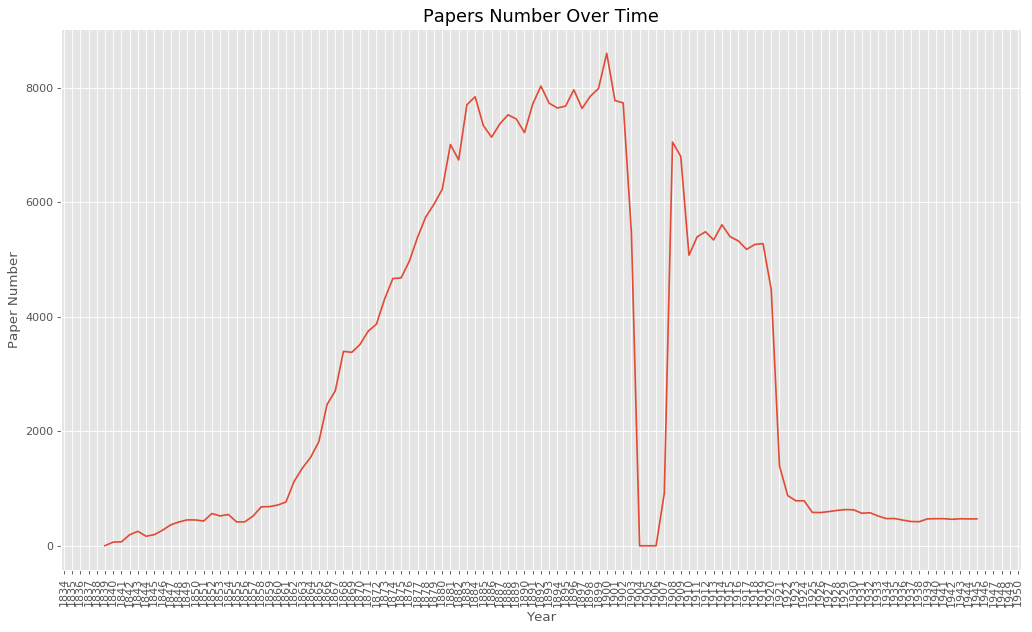

In [24]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot_date(df_paper_year.index, df_paper_year['count'], '-')
plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.title("Papers Number Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

### 3.4 Papers Distribution by Region Over Time

In [17]:
# convert dataframe to time series
df_paper_region_ts = (df_paper
                      .groupby([df_paper['date'], df_paper['region']])
                      .size()
                      .reset_index(name='count')
                      .sort_values('date', ascending=True))
df_paper_region_ts = df_paper_region_ts.set_index('date')
df_paper_region_ts.sort_index()
df_paper_region_ts.T

date,1839-08-21 00:00:00,1839-09-06 00:00:00,1840-04-18 00:00:00,1840-04-25 00:00:00,1840-05-02 00:00:00,1840-05-09 00:00:00,1840-05-16 00:00:00,1840-05-23 00:00:00,1840-05-30 00:00:00,1840-06-06 00:00:00,1840-06-13 00:00:00,1840-06-15 00:00:00,1840-06-19 00:00:00,1840-06-20 00:00:00,1840-06-25 00:00:00,1840-06-27 00:00:00,1840-07-02 00:00:00,1840-07-04 00:00:00,1840-07-09 00:00:00,1840-07-11 00:00:00,1840-07-16 00:00:00,1840-07-18 00:00:00,1840-07-23 00:00:00,1840-07-25 00:00:00,1840-07-30 00:00:00,1840-08-01 00:00:00,1840-08-06 00:00:00,1840-08-08 00:00:00,1840-08-13 00:00:00,1840-08-15 00:00:00,1840-08-20 00:00:00,1840-08-22 00:00:00,1840-08-27 00:00:00,1840-08-29 00:00:00,1840-09-03 00:00:00,1840-09-05 00:00:00,1840-09-10 00:00:00,1840-09-12 00:00:00,1840-09-17 00:00:00,1840-09-19 00:00:00,1840-09-24 00:00:00,1840-10-01 00:00:00,1840-10-03 00:00:00,1840-10-08 00:00:00,1840-10-10 00:00:00,1840-10-15 00:00:00,1840-10-17 00:00:00,1840-10-22 00:00:00,1840-10-24 00:00:00,1840-10-29 00:00:00,1840-10-31 00:00:00,1840-11-05 00:00:00,1840-11-07 00:00:00,1840-11-12 00:00:00,1840-11-14 00:00:00,1840-11-19 00:00:00,1840-11-21 00:00:00,1840-11-26 00:00:00,1840-11-28 00:00:00,1840-12-03 00:00:00,...,1945-11-13 00:00:00,1945-11-13 00:00:00,1945-11-14 00:00:00,1945-11-14 00:00:00,1945-11-15 00:00:00,1945-11-16 00:00:00,1945-11-16 00:00:00,1945-11-17 00:00:00,1945-11-19 00:00:00,1945-11-20 00:00:00,1945-11-20 00:00:00,1945-11-21 00:00:00,1945-11-21 00:00:00,1945-11-22 00:00:00,1945-11-23 00:00:00,1945-11-23 00:00:00,1945-11-24 00:00:00,1945-11-26 00:00:00,1945-11-27 00:00:00,1945-11-27 00:00:00,1945-11-28 00:00:00,1945-11-28 00:00:00,1945-11-29 00:00:00,1945-11-30 00:00:00,1945-11-30 00:00:00,1945-12-01 00:00:00,1945-12-01 00:00:00,1945-12-03 00:00:00,1945-12-04 00:00:00,1945-12-04 00:00:00,1945-12-05 00:00:00,1945-12-05 00:00:00,1945-12-06 00:00:00,1945-12-07 00:00:00,1945-12-07 00:00:00,1945-12-08 00:00:00,1945-12-10 00:00:00,1945-12-11 00:00:00,1945-12-11 00:00:00,1945-12-12 00:00:00,1945-12-12 00:00:00,1945-12-13 00:00:00,1945-12-14 00:00:00,1945-12-14 00:00:00,1945-12-15 00:00:00,1945-12-17 00:00:00,1945-12-18 00:00:00,1945-12-18 00:00:00,1945-12-19 00:00:00,1945-12-19 00:00:00,1945-12-20 00:00:00,1945-12-21 00:00:00,1945-12-21 00:00:00,1945-12-22 00:00:00,1945-12-24 00:00:00,1945-12-26 00:00:00,1945-12-27 00:00:00,1945-12-28 00:00:00,1945-12-29 00:00:00,1945-12-31 00:00:00
region,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Northland,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,Wellington,Northland,...,Canterbury,Wellington,Auckland,Wellington,Wellington,Wellington,Canterbury,Wellington,Wellington,Canterbury,Wellington,Auckland,Wellington,Wellington,Canterbury,Wellington,Wellington,Wellington,Wellington,Canterbury,Auckland,Wellington,Wellington,Canterbury,Wellington,Wellington,unknown,Wellington,Canterbury,Wellington,Wellington,Auckland,Wellington,Canterbury,Wellington,Wellington,Wellington,Canterbury,Wellington,Auckland,Wellington,Wellington,Wellington,Canterbury,Wellington,Wellington,Canterbury,Wellington,Auckland,Wellington,Wellington,Canterbury,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington,Wellington
count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [18]:
# time series dataframe by regions
df_paper_region_year = (df_paper_region_ts
                        .groupby('region')['count']
                        .resample('AS').sum()
                        .unstack('region').fillna(0))

df_paper_region_year.sample(5)

region,Auckland,Bay of Plenty,Canterbury,Gisborne,Hawke's Bay,Manawatu-Wanganui,Marlborough,National,Nelson,Northland,Otago,Taranaki,Waikato,Wellington,West Coast,unknown
date,,,,,,,,,,,,,,,,
1883-01-01,352.0,164.0,723.0,299.0,602.0,1163.0,304.0,0.0,590.0,0.0,1284.0,611.0,490.0,306.0,761.0,52.0
1939-01-01,51.0,0.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.0,0.0,12.0
1880-01-01,321.0,151.0,718.0,209.0,307.0,707.0,130.0,0.0,461.0,0.0,1244.0,385.0,465.0,308.0,765.0,53.0
1907-01-01,1.0,3.0,112.0,60.0,3.0,318.0,307.0,2.0,61.0,0.0,9.0,9.0,6.0,14.0,6.0,5.0
1919-01-01,150.0,201.0,506.0,307.0,0.0,591.0,304.0,52.0,306.0,302.0,557.0,613.0,454.0,614.0,304.0,16.0


**Plot all regions:**

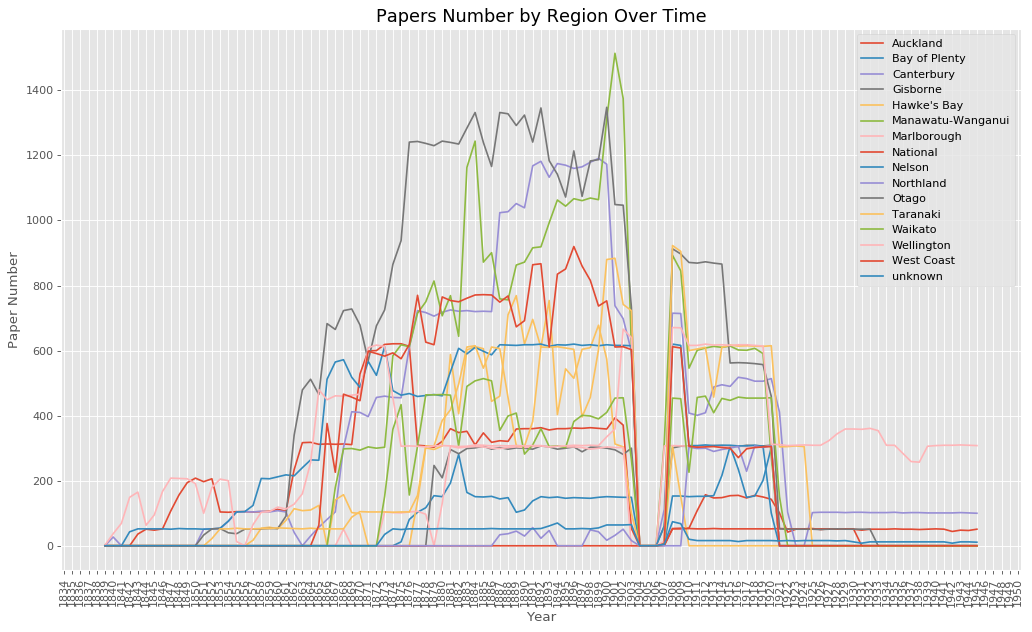

In [19]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

for i, c in enumerate(df_paper_region_year.columns):
    plt.plot_date(df_paper_region_year.index, df_paper_region_year[df_paper_region_year.columns[i]], '-')
    
plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.xticks(rotation='90')
plt.title("Papers Number by Region Over Time", fontdict=dict(size=16))
ax.legend()
plt.tight_layout()
plt.show()

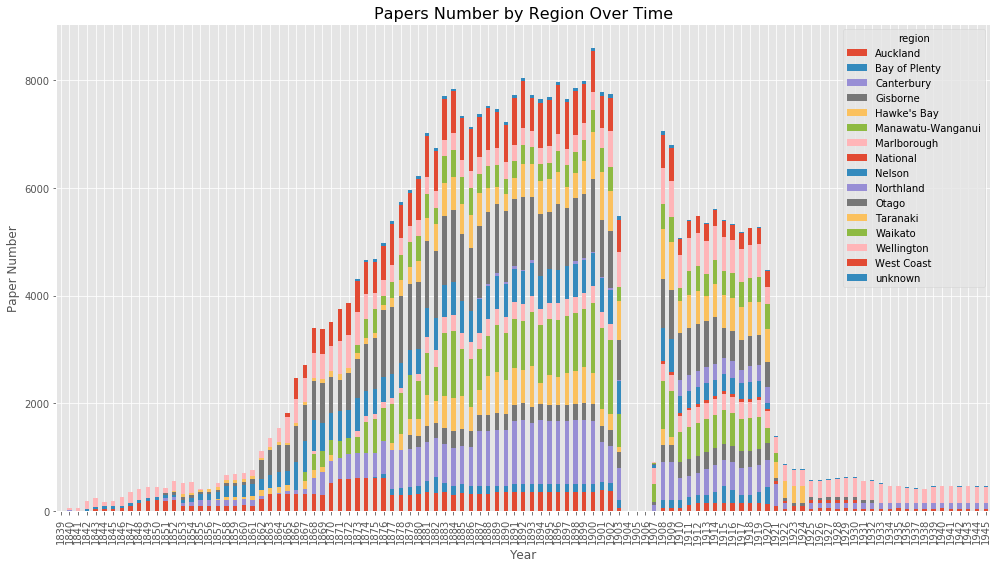

In [20]:
# convert date to year format string
df_paper_region_year_bar = df_paper_region_year.copy(deep=True)
df_paper_region_year_bar.index = df_paper_region_year_bar.index.strftime('%Y')

# plot
df_paper_region_year_bar.loc[:, df_paper_region_year_bar.columns].plot.bar(stacked=True, figsize=(14,8))

plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.xticks(rotation='90')
plt.title("Papers Number by Region Over Time", fontdict=dict(size=16))
plt.tight_layout()
plt.show()

**Plot 4 most population cities nowadays (Auckland, Wellington, Canterbury and Otago):**

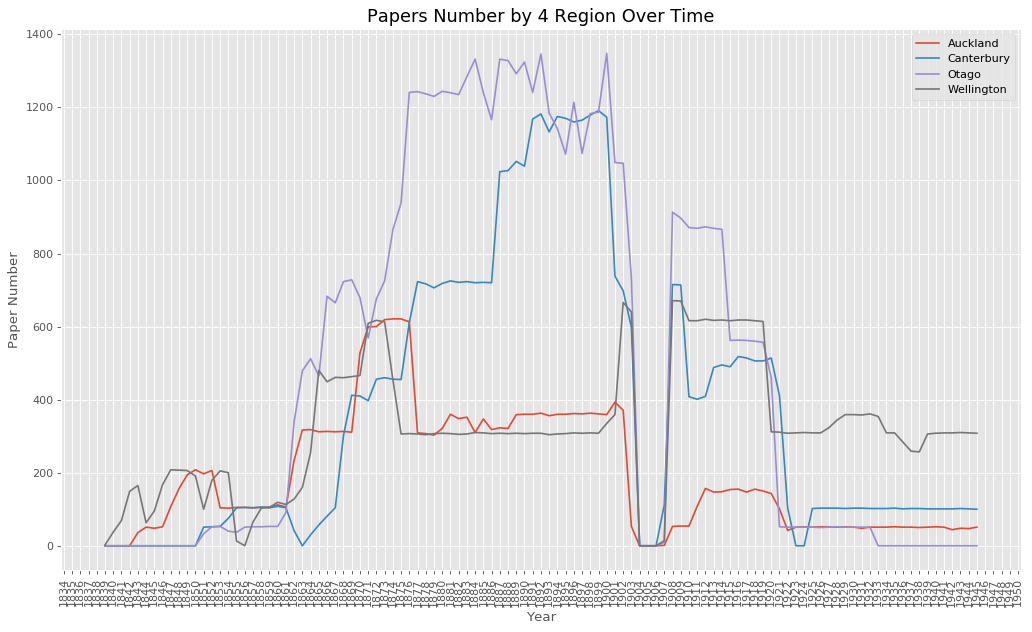

In [21]:
# set regions
list_regions = ['Auckland', 'Wellington', 'Canterbury', 'Otago']

# plot
fig, ax = plt.subplots(figsize=(13, 8), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

for i, c in enumerate(df_paper_region_year.columns):
    if c in list_regions:
        plt.plot_date(df_paper_region_year.index, df_paper_region_year[df_paper_region_year.columns[i]], '-')
        
plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.xticks(rotation='90')
plt.title("Papers Number by 4 Region Over Time", fontdict=dict(size=16))
ax.legend()
plt.tight_layout()
plt.show()

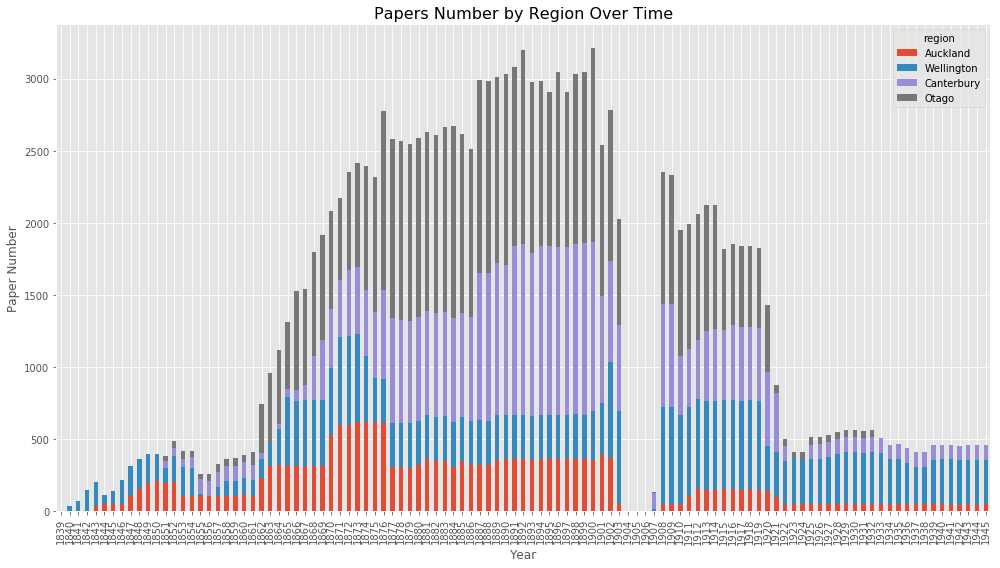

In [22]:
df_paper_region_year_bar.loc[:, list_regions].plot.bar(stacked=True, figsize=(14,8))

plt.xlabel('Year')
plt.ylabel('Paper Number')
plt.xticks(rotation='90')
plt.title("Papers Number by Region Over Time", fontdict=dict(size=16))
plt.tight_layout()
plt.show()

---

In [23]:
sc.stop()
gc.collect()

32317